In [1]:
import os
import json
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
FIND_DIR = "finding"
OUTPUT_PATH = "eval/finding_evaluation.csv"
Path("eval").mkdir(exist_ok=True)

In [3]:
# Load all jsonl files
def load_finding_output(model_tag):
    findings = {}
    path = os.path.join(FIND_DIR, f"{model_tag}.jsonl")
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            findings[obj["pmid"]] = set(obj["finding_ids"])
    return findings

In [4]:
# Load predictions
pred = {tag: load_finding_output(tag) for tag in ["gpt4o", "claude", "llama"]}
all_pmids = set().union(*[set(v.keys()) for v in pred.values()])

In [5]:
# Horizontal Comparison (Cross-model Agreement)
rows = []
for pmid in sorted(all_pmids):
    g = pred["gpt4o"].get(pmid, set())
    c = pred["claude"].get(pmid, set())
    l = pred["llama"].get(pmid, set())
    rows.append({
        "pmid": pmid,
        "gpt4o_cnt": len(g),
        "claude_cnt": len(c),
        "llama_cnt": len(l),
        "jaccard_gpt_claude": len(g & c) / len(g | c) if g | c else 1.0,
        "jaccard_gpt_llama": len(g & l) / len(g | l) if g | l else 1.0,
        "jaccard_claude_llama": len(c & l) / len(c | l) if c | l else 1.0,
        "intersect_all": len(g & c & l),
        "union_all": len(g | c | l),
        "gpt4o_only": sorted(g - (c | l)),
        "claude_only": sorted(c - (g | l)),
        "llama_only": sorted(l - (g | c)),
    })

df = pd.DataFrame(rows)
df.to_csv(OUTPUT_PATH, index=False)

In [6]:
# Summary Metrics
summary = {
    "Total Abstracts": len(df),
    "Avg Findings per Abstract": df[["gpt4o_cnt", "claude_cnt", "llama_cnt"]].mean().to_dict(),
    "% Exact Agreement (all 3)": (df["intersect_all"] == df["union_all"]).mean(),
    "% Partial Overlap (all 3 > 0 but not same)": ((df["intersect_all"] > 0) & (df["intersect_all"] < df["union_all"]).astype(int)).mean(),
}

print("=== Finding Evaluation Summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")

=== Finding Evaluation Summary ===
Total Abstracts: 100
Avg Findings per Abstract: {'gpt4o_cnt': 3.07, 'claude_cnt': 3.62, 'llama_cnt': 3.66}
% Exact Agreement (all 3): 0.23
% Partial Overlap (all 3 > 0 but not same): 0.59


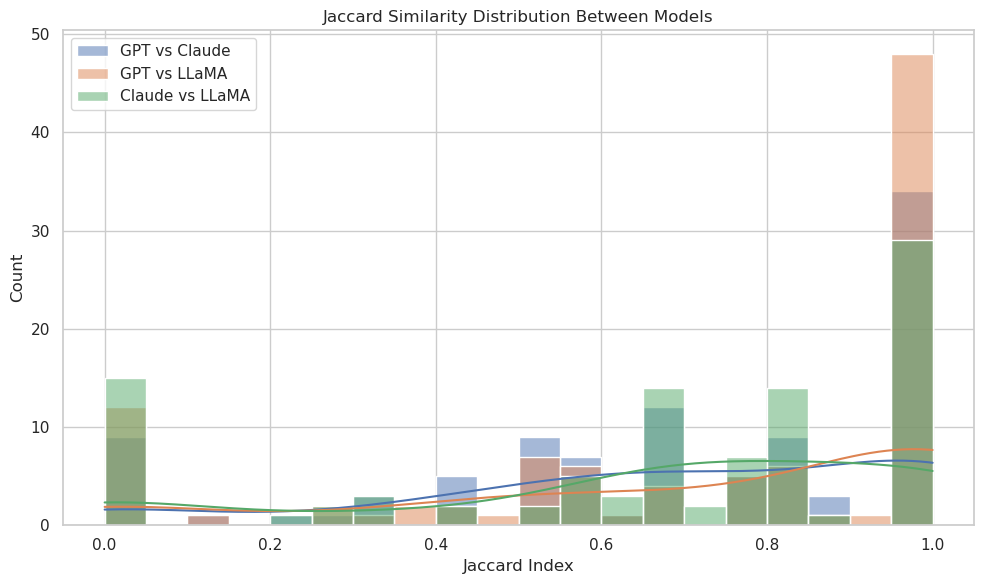

In [7]:
# Visualization
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df["jaccard_gpt_claude"], label="GPT vs Claude", kde=True, bins=20)
sns.histplot(df["jaccard_gpt_llama"], label="GPT vs LLaMA", kde=True, bins=20)
sns.histplot(df["jaccard_claude_llama"], label="Claude vs LLaMA", kde=True, bins=20)
plt.title("Jaccard Similarity Distribution Between Models")
plt.xlabel("Jaccard Index")
plt.legend()
plt.tight_layout()
plt.savefig("eval/finding_jaccard_hist.png")
plt.show()

In [8]:
# Identify disagreements for manual inspection
low_agree = df[df["intersect_all"] < df["union_all"]].sort_values("union_all", ascending=False)
low_agree[["pmid", "gpt4o_only", "claude_only", "llama_only"]].head(10).to_csv("eval/finding_disagreement_samples.csv", index=False)

print("\nSaved evaluation results to eval/*.csv and eval/*.png")


Saved evaluation results to eval/*.csv and eval/*.png
